<h1> Time series prediction, end-to-end </h1>

This notebook illustrates several models to find the next value of a time-series:
<ol>
<li> Linear
<li> DNN
<li> CNN 
<li> RNN
</ol>

In [1]:
# change these to try this notebook out
BUCKET = 'qwiklabs-gcp-ea35c49d45c58ca4'
PROJECT = 'qwiklabs-gcp-ea35c49d45c58ca4'
REGION = 'us-central1'
SEQ_LEN = 50

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['SEQ_LEN'] = str(SEQ_LEN)
os.environ['TFVERSION'] = '1.8'

<h3> Simulate some time-series data </h3>

Essentially a set of sinusoids with random amplitudes and frequencies.

In [3]:
import tensorflow as tf
print(tf.__version__)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0


/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


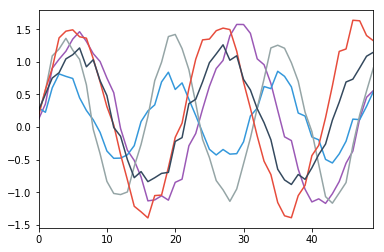

In [4]:
import numpy as np
import seaborn as sns

def create_time_series():
  freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  noise = [np.random.random()*0.3 for i in range(SEQ_LEN)] # -0.3 to +0.3 uniformly distributed
  x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl + noise
  return x

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
  sns.tsplot( create_time_series(), color=flatui[i%len(flatui)] );  # 5 series

In [5]:
def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in range(0, N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

import os
try:
  os.makedirs('data/sines/')
except OSError:
  pass
to_csv('data/sines/train-1.csv', 1000)  # 1000 sequences
to_csv('data/sines/valid-1.csv', 250)

In [6]:
!head -5 data/sines/*-1.csv

==> data/sines/train-1.csv <==
0.048797744903732065,0.3785991469421923,0.7268594626970557,0.7901389975942229,0.8988087703434741,0.5131240971305325,0.3274799803345083,-0.04513188867627027,-0.19702763784062408,-0.46590950165663003,-0.39472430090782346,-0.3400723233876243,-0.2811812713709952,0.07582340183113465,0.2748842506394,0.6678046227874421,0.8902722457478964,0.9453012040768909,0.6809230107396071,0.4045210750723113,0.2461936481082793,-0.1153012386420956,-0.4570022781108033,-0.3724324273577725,-0.3921615928344972,-0.45408822677830735,-0.0238906308357012,0.276031416527734,0.619467539896611,0.7511886017574363,0.9318139537289503,0.751586921498371,0.45497255609238607,0.42584996332665337,0.035022005678345486,-0.3051726298232471,-0.38553495346506805,-0.3872100843478879,-0.3744214340810884,-0.1986360090084672,0.14972453164912453,0.30023892540962505,0.6638459145454926,0.9307536553648883,0.6680627943362911,0.658057449761742,0.3946090830664403,0.24655725853907098,-0.2717563712660707,-0.45189816

<h3> Train model locally </h3>

Make sure the code works as intended.

The `model.py` and `task.py` containing the model code is in <a href="sinemodel">sinemodel/</a>

**Complete the TODOs in `model.py` before proceeding!**

Once you've completed the TODOs, set `--model` below to the appropriate model (linear,dnn,cnn,rnn,rnn2 or rnnN) and run it locally for a few steps to test the code.

In [7]:
%%bash
DATADIR=$(pwd)/data/sines
OUTDIR=$(pwd)/trained/sines
rm -rf $OUTDIR
gcloud ml-engine local train \
   --module-name=sinemodel.task \
   --package-path=${PWD}/sinemodel \
   -- \
   --train_data_path="${DATADIR}/train-1.csv" \
   --eval_data_path="${DATADIR}/valid-1.csv"  \
   --output_dir=${OUTDIR} \
   --model=dnn --train_steps=10 --sequence_length=$SEQ_LEN




INFO:tensorflow:TF_CONFIG environment variable: {u'environment': u'cloud', u'cluster': {}, u'job': {u'args': [u'--train_data_path=/home/jupyter/AdvancedMLwithTFonGCP/courses/machine_learning/deepdive/09_sequence/labs/data/sines/train-1.csv', u'--eval_data_path=/home/jupyter/AdvancedMLwithTFonGCP/courses/machine_learning/deepdive/09_sequence/labs/data/sines/valid-1.csv', u'--output_dir=/home/jupyter/AdvancedMLwithTFonGCP/courses/machine_learning/deepdive/09_sequence/labs/trained/sines', u'--model=dnn', u'--train_steps=10', u'--sequence_length=50'], u'job_name': u'sinemodel.task'}, u'task': {}}
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 60, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3495700150>, '_model_dir': '/home/jupyter/AdvancedMLwithTFonGCP/courses/machine_learning/deepdive/09_sequence/labs/trained/sines/', '

<h3> Cloud ML Engine </h3>

Now to train on Cloud ML Engine with more data.

In [8]:
import shutil
shutil.rmtree('data/sines', ignore_errors=True)
os.makedirs('data/sines/')
for i in range(0,10):
  to_csv('data/sines/train-{}.csv'.format(i), 1000)  # 1000 sequences
  to_csv('data/sines/valid-{}.csv'.format(i), 250)

In [9]:
%%bash
gsutil -m rm -rf gs://${BUCKET}/sines/*
gsutil -m cp data/sines/*.csv gs://${BUCKET}/sines

CommandException: 1 files/objects could not be removed.
Copying file://data/sines/train-1.csv [Content-Type=text/csv]...
Copying file://data/sines/train-0.csv [Content-Type=text/csv]...
Copying file://data/sines/train-2.csv [Content-Type=text/csv]...                
Copying file://data/sines/train-3.csv [Content-Type=text/csv]...
Copying file://data/sines/train-5.csv [Content-Type=text/csv]...                
Copying file://data/sines/train-4.csv [Content-Type=text/csv]...                
Copying file://data/sines/train-6.csv [Content-Type=text/csv]...                
Copying file://data/sines/valid-5.csv [Content-Type=text/csv]...                
Copying file://data/sines/valid-0.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-1.csv [Content-Type=text/csv]...
Copying file://data/sines/valid-6.csv [Content-Type=text/csv]...                
Copying file://data/sines/train-7.csv [Content-Type=text/csv]...                
Copying file://data/sines/valid-7.csv [Content-Type=

In [10]:
%%bash
for MODEL in linear dnn cnn rnn rnn2 rnnN; do
  OUTDIR=gs://${BUCKET}/sinewaves/${MODEL}
  JOBNAME=sines_${MODEL}_$(date -u +%y%m%d_%H%M%S)
  gsutil -m rm -rf $OUTDIR
  gcloud ml-engine jobs submit training $JOBNAME \
     --region=$REGION \
     --module-name=sinemodel.task \
     --package-path=${PWD}/sinemodel \
     --job-dir=$OUTDIR \
     --staging-bucket=gs://$BUCKET \
     --scale-tier=BASIC_GPU \
     --runtime-version=$TFVERSION \
     -- \
     --train_data_path="gs://${BUCKET}/sines/train*.csv" \
     --eval_data_path="gs://${BUCKET}/sines/valid*.csv"  \
     --output_dir=$OUTDIR \
     --train_steps=3000 --sequence_length=$SEQ_LEN --model=$MODEL
done

jobId: sines_linear_190923_063103
state: QUEUED
jobId: sines_dnn_190923_063107
state: QUEUED
jobId: sines_cnn_190923_063111
state: QUEUED
jobId: sines_rnn_190923_063114
state: QUEUED
jobId: sines_rnn2_190923_063117
state: QUEUED
jobId: sines_rnnN_190923_063121
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [sines_linear_190923_063103] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe sines_linear_190923_063103

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs sines_linear_190923_063103
CommandException: 1 files/objects could not be removed.
Job [sines_dnn_190923_063107] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe sines_dnn_190923_063107

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs sines_dnn_190923_063107
CommandException: 1 files/objects could not be removed.
Job [sines_cnn_190923_063111] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe sines_cnn_190923_063111

or contin

## Monitor training with TensorBoard

Use this cell to launch tensorboard. If tensorboard appears blank try refreshing after 5 minutes

In [11]:
from google.datalab.ml import TensorBoard
TensorBoard().start('gs://{}/sinewaves'.format(BUCKET))

TensorBoard was started successfully with pid 10392. Click here to access it.

10392

In [12]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print('Stopped TensorBoard with pid {}'.format(pid))

Stopped TensorBoard with pid 10392


## Results

Complete the below table with your own results! Then compare your results to the results in the solution notebook.

| Model | Sequence length | # of steps | Minutes | RMSE |
| --- | ----| --- | --- | --- | 
| linear | 50 | 3000 | - | - |
| dnn | 50 | 3000 | - | - |
| cnn | 50 | 3000 | - | - |
| rnn | 50 | 3000 | - | - |
| rnn2 | 50 | 3000 | - | - |
| rnnN | 50 | 3000 | - | - |

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License